"objective": "multiclass" и "objective": "multiclassova"
multiclass -> softmax, multiclassova -> One-vs-All; softmax дает 1 для сумм вероятностей, One-vs-All не дает
Посмотреть pruner для постоянных lr

In [1]:
import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import (
    confusion_matrix,
    log_loss,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt

In [2]:
steel_initial = pd.read_csv("steel.csv")

In [3]:
long_column_names = {
    "V1": "X_Minimum",
    "V2": "X_Maximum",
    "V3": "Y_Minimum",
    "V4": "Y_Maximum",
    "V5": "Pixels_Areas",
    "V6": "X_Perimeter",
    "V7": "Y_Perimeter",
    "V8": "Sum_of_Luminosity",
    "V9": "Minimum_of_Luminosity",
    "V10": "Maximum_of_Luminosity",
    "V11": "Length_of_Conveyer",
    "V12": "TypeOfSteel_A300",
    "V13": "TypeOfSteel_A400",
    "V14": "Steel_Plate_Thickness",
    "V15": "Edges_Index",
    "V16": "Empty_Index",
    "V17": "Square_Index",
    "V18": "Outside_X_Index",
    "V19": "Edges_X_Index",
    "V20": "Edges_Y_Index",
    "V21": "Outside_Global_Index",
    "V22": "LogOfAreas",
    "V23": "Log_X_Index",
    "V24": "Log_Y_Index",
    "V25": "Orientation_Index",
    "V26": "Luminosity_Index",
    "V27": "SigmoidOfAreas",
    "V28": "Pastry",
    "V29": "Z_Scratch",
    "V30": "K_Scratch", #K_Scatch
    "V31": "Stains",
    "V32": "Dirtiness",
    "V33": "Bumps",
    "Class": "Other_Faults",
}

In [4]:
steel_long_names = steel_initial.rename(columns=long_column_names)

In [5]:
steel_long_names["Other_Fault"] = pd.get_dummies(data=steel_long_names["Other_Faults"], prefix="Other_Faults")["Other_Faults_2"]

In [6]:
steel_long_names.drop("Other_Faults", axis=1, inplace=True)

# Работа с метками

### Кодирование меток в один столбец меток

In [7]:
steel_long_names["Fault_Label"] = steel_long_names[
    ["Pastry", "Z_Scratch", "K_Scratch", "Stains", "Dirtiness", "Bumps", "Other_Fault"]
].dot(
    steel_long_names[
        [
            "Pastry",
            "Z_Scratch",
            "K_Scratch",
            "Stains",
            "Dirtiness",
            "Bumps",
            "Other_Fault",
        ]
    ].columns
)

In [8]:
steel_long_names.drop(["Pastry", "Z_Scratch", "K_Scratch", "Stains", "Dirtiness", "Bumps", "Other_Fault"], axis=1, inplace=True)

### Кодирование меток в числовой вид

In [9]:
le = preprocessing.LabelEncoder()
le.fit(steel_long_names["Fault_Label"]) #fit_transform

LabelEncoder()

In [10]:
steel_long_names["Fault_Label"] = le.transform(steel_long_names["Fault_Label"])

# Работа с признаками

### Удаление лишнего

In [11]:
# TypeOfSteel_A400 и TypeOfSteel_A300 по смыслу бинарные (не категориальные), т.к. имеют корреляцию -1, т.е. полностью инверсные
steel_long_names.drop("TypeOfSteel_A400", axis=1, inplace=True)

### Конструирование дополнительных признаков

In [12]:
steel_long_names["Delta_X"] = steel_long_names["X_Maximum"] - steel_long_names["X_Minimum"]

In [13]:
steel_long_names["Delta_Y"] = steel_long_names["Y_Maximum"] - steel_long_names["Y_Minimum"]

In [14]:
steel_long_names["Delta_Sum"] = steel_long_names["Delta_X"] + steel_long_names["Delta_Y"]

In [15]:
steel_long_names["Sum_Perimeter"] = steel_long_names["X_Perimeter"] + steel_long_names["Y_Perimeter"]

In [16]:
steel_long_names["YdivX_Perimeter"] = steel_long_names["Y_Perimeter"]/steel_long_names["X_Perimeter"]

In [17]:
steel_long_names["Delta_Luminosity"] = steel_long_names["Maximum_of_Luminosity"] - steel_long_names["Minimum_of_Luminosity"]

In [18]:
steel_long_names["Edges_Sum_Index"] = steel_long_names["Edges_X_Index"] + steel_long_names["Edges_Y_Index"]

In [19]:
steel_long_names["Log_Sum_Index"] = steel_long_names["Log_X_Index"] + steel_long_names["Log_Y_Index"]

In [20]:
steel_long_names

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,SigmoidOfAreas,Fault_Label,Delta_X,Delta_Y,Delta_Sum,Sum_Perimeter,YdivX_Perimeter,Delta_Luminosity,Edges_Sum_Index,Log_Sum_Index
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.5822,4,8,44,52,61,2.588235,32,1.4706,2.5466
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.2984,4,6,29,35,40,3.000000,39,1.5667,2.2406
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.2150,4,6,18,24,27,2.375000,26,1.6974,2.0335
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.5212,4,7,45,52,58,3.461538,27,1.5385,2.4983
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,1.0000,4,17,257,274,320,4.333333,89,1.2718,3.6404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,0.7254,3,28,16,44,76,0.407407,22,1.2458,2.6513
1937,144,175,340581,340598,287,44,24,34599,112,133,...,0.8173,3,31,17,48,68,0.545455,21,1.4129,2.7219
1938,145,174,386779,386794,292,40,22,37572,120,140,...,0.7079,3,29,15,44,62,0.550000,20,1.4068,2.6385
1939,137,170,422497,422528,419,97,47,52715,117,140,...,0.9919,3,33,31,64,144,0.484536,23,0.9998,3.0099


### Разбивка на пару признаки-метка класса

In [21]:
y_steel = steel_long_names["Fault_Label"]

In [22]:
X_steel = steel_long_names.drop("Fault_Label", axis=1, inplace=False)

# Настройка обучения

### Разбивка на train, valid, test для lightgbm

#### Схема обучения: 

5 SKF, внутри каждого разбиение через train/test (5x2 split)
#### <u> XXXX XXXX XXXX  </u> *VVVV*  **YYYY** 
#### <u> XXXX XXXX </u> *VVVV* **YYYY** <u> XXXX  </u>
#### <u> XXXX </u> *VVVV* **YYYY** <u> XXXX XXXX  </u>
#### *VVVV* **YYYY** <u> XXXX XXXX XXXX </u>
#### **YYYY** <u> XXXX XXXX XXXX  </u> *VVVV* <br/><br/>
#### Здесь
#### <u> XXXX </u> - train блок данных
#### *VVVV* - valid блок данных 
#### **YYYY** - test блок данных 
<br/><br/>
Сумма ошибки на test представляет ошибку обобщения (generalization error), которую минимизируем

In [23]:
# Внешнее 5 SKF
outer_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [24]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [25]:
# 5x2 setup
def objective_LGB(trial):

    results = {}  # dict for record_evaluation callback
    split_iteration = {}  # dict for best iterations in each fold
    inner_valid_values = {}  # dict for valid score inside kfold
    outter_valid_values = {}  # dict for valid score outside kfold

    hyperparameters = {
        "objective": "multiclass",
        "metric": "auc_mu",  # "multiclassova"
        "num_class": 7,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 30),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 3, 100),
        "min_sum_hessian_in_leaf": trial.suggest_loguniform(
            "min_sum_hessian_in_leaf", 1e-5, 9e-1
        ),
        "feature_pre_filter": False,
        "verbose": -1,
    }
    # Split to 5 sfk manually
    for split_number, data_splits in enumerate(outer_splitter.split(X_steel, y_steel)):
        # In single fold split to train/valid manually
        train_inner_X, valid_inner_X, train_inner_y, valid_inner_y = train_test_split(
            X_steel.reset_index(drop=True).loc[data_splits[0]],
            y_steel.reset_index(drop=True).loc[data_splits[0]],
            test_size=0.2,
            random_state=1,
            stratify=y_steel.reset_index(drop=True).loc[data_splits[0]],
        )

        train_set = lgb.Dataset(train_inner_X, label=train_inner_y)
        valid_set = lgb.Dataset(valid_inner_X, label=valid_inner_y)

        # Train
        lgb_model = lgb.train(
            params=hyperparameters,
            train_set=train_set,
            valid_names=["train", "eval"],
            num_boost_round=1000,
            valid_sets=[train_set, valid_set],
            verbose_eval=100,
            early_stopping_rounds=25,
            callbacks=[lgb.record_evaluation(results)],
        )

        split_iteration.update({f"{split_number}": lgb_model.best_iteration})

        inner_valid_values.update({f"{split_number}": results["eval"]["auc_mu"][-1]})

        outter_valid_values.update(
            {
                f"{split_number}": roc_auc_score(
                    y_true=y_steel.reset_index(drop=True).loc[data_splits[1]],
                    y_score=lgb_model.predict(
                        X_steel.reset_index(drop=True).loc[data_splits[1]],
                    ),
                    multi_class="ovo",
                )
            }
        )

        print(
            f"Best iteration, split №{split_number} = {lgb_model.best_iteration}\n"
        )  #

    trial.set_user_attr("Best_iteration", split_iteration)

    trial.set_user_attr("Best_inner_valid_score", inner_valid_values)

    trial.set_user_attr("Outter_valid_score", outter_valid_values)

    mean_val = np.mean(list(outter_valid_values.values()))
    trial.set_user_attr("Mean_valid_score", mean_val)

    mean_std = np.std(list(outter_valid_values.values()))
    trial.set_user_attr("Std_valid_score", mean_std)

    trial.set_user_attr("Mean_iterations", np.mean(list(split_iteration.values())))

    print(f"AUC: {mean_val} +\- {mean_std}\n")

    return mean_val

#### Проверка работы без 5 SKF схемы, оставлена для примера

In [26]:
# pruner_LGB = optuna.pruners.MedianPruner(n_startup_trials=4, n_warmup_steps=100, interval_steps=10)
study_LGB = optuna.create_study(direction="maximize")  # , pruner=pruner_LGB
study_LGB.optimize(objective_LGB, n_trials=200)

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=63
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[24]	train's auc_mu: 0.967914	eval's auc_mu: 0.953954
Best iteration, split №0 = 24

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=63
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[36]	train's auc_mu: 0.969539	eval's auc_mu: 0.954621
Best iteration, split №1 = 36

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=63
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[25]	train's auc_mu: 0.962069	eval's auc_mu: 0.977775
Best iteration, split №2 = 25

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=60 will be ignored. Curr

In [27]:
study_LGB.best_trial.number

183

In [28]:
study_LGB.best_trial.user_attrs

{'Best_iteration': {'0': 111, '1': 156, '2': 128, '3': 162, '4': 200},
 'Best_inner_valid_score': {'0': 0.9780584023070794,
  '1': 0.9794689398393102,
  '2': 0.9905737608829539,
  '3': 0.9882883225893978,
  '4': 0.9818858631080852},
 'Outter_valid_score': {'0': 0.9774005359284965,
  '1': 0.9706561884766323,
  '2': 0.9647045205739114,
  '3': 0.9626383036698775,
  '4': 0.9739633264625011},
 'Mean_valid_score': 0.9698725750222839,
 'Std_valid_score': 0.005532846673793356,
 'Mean_iterations': 151.4}

In [29]:
study_LGB.best_params

{'learning_rate': 0.04421146450548724,
 'lambda_l1': 0.019446266251178727,
 'lambda_l2': 0.019936680795028753,
 'min_gain_to_split': 0.2441946507900477,
 'num_leaves': 9,
 'feature_fraction': 0.4461058646632399,
 'bagging_fraction': 0.7830309294254875,
 'bagging_freq': 4,
 'min_child_samples': 33,
 'min_data_in_leaf': 11,
 'min_sum_hessian_in_leaf': 0.0004641900587783676}

In [30]:
parameters_for_fit_LGB = {
    "objective": "multiclass",
    "metric": "auc_mu",
    "num_class": 7,
    "visible":-1,
    "verbose":-1,
    "feature_pre_filter": False,
    **study_LGB.best_params,
}

In [31]:
lgb_predict = pd.DataFrame(
    index=X_steel.index,
    columns=["Label"],
)

# Работа с моделью

### При помощи найденных гиперпараметров найдем еще раз out-of-fold предсказания.
На этот раз окончательные ответы (до этого были вероятности). Примем за предсказанную метку метку с наибольшей вероятностю, среди предсказанных для сэмпла.

In [32]:
for train_split, predict_split in outer_splitter.split(X_steel, y_steel):
    lgb_model = lgb.train(
        parameters_for_fit_LGB,
        train_set=lgb.Dataset(
            data=X_steel.reset_index(drop=True).loc[train_split],
            label=y_steel.reset_index(drop=True).loc[train_split],
        ),
        verbose_eval=False,
        num_boost_round=int(
            np.rint(study_LGB.best_trial.user_attrs["Mean_iterations"])
        ),
    )
    lgb_predict.loc[predict_split, "Label"] = lgb_model.predict(
        data=X_steel.reset_index(drop=True).loc[predict_split]
    ).argmax(1)
print("Outer splitter answers\n", lgb_predict["Label"].head())

[LightGBM] [Warning] Unknown parameter: visible
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] Unknown parameter: visible
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] Unknown parameter: visible
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] Unknown parameter: visible
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] Unknown parameter: visible
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=11
Outer splitter answers
 0    4
1    4
2    4
3    3
4    3
Name: Label, dtype: object


In [33]:
(fig, ax) = plt.subplots(figsize=(20, 10))
plt.close()

In [34]:
lgb.plot_importance(lgb_model, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

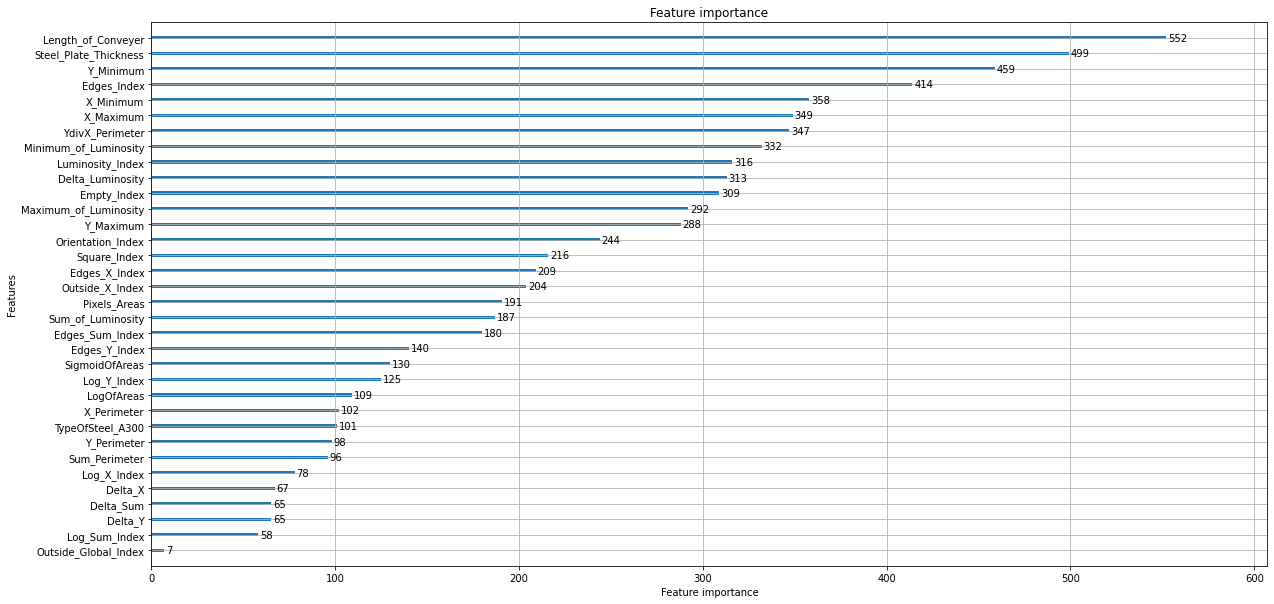

In [35]:
fig

YdivX_Perimeter и Delta_Luminosity являются значимыми, остальные сконструированные менее значимы

In [36]:
# Словарь {метка_класса: закодированная_метка_класса}
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [37]:
print(classification_report(y_steel, lgb_predict["Label"].astype("int32"), target_names=le_name_mapping))

              precision    recall  f1-score   support

       Bumps       0.67      0.66      0.67       402
   Dirtiness       0.98      0.80      0.88        55
   K_Scratch       0.97      0.96      0.97       391
 Other_Fault       0.72      0.76      0.74       673
      Pastry       0.67      0.63      0.65       158
      Stains       0.94      0.93      0.94        72
   Z_Scratch       0.92      0.91      0.91       190

    accuracy                           0.79      1941
   macro avg       0.84      0.81      0.82      1941
weighted avg       0.79      0.79      0.79      1941



Метрика AUCmu выбрана специально для получения более-менее сбалансированного результата по всем меткам классов.
Худший результат у метки Pastry. Как показывают результаты Kaggle kernels, Pastry самая проблемная метка класса в данном датасете.

In [39]:
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_steel, lgb_predict["Label"].astype("int32")), display_labels=le_name_mapping)

In [40]:
(fig_cmd, ax_cmd) = plt.subplots(figsize=(20, 10))
plt.close()

In [41]:
cmd.plot(ax=ax_cmd)

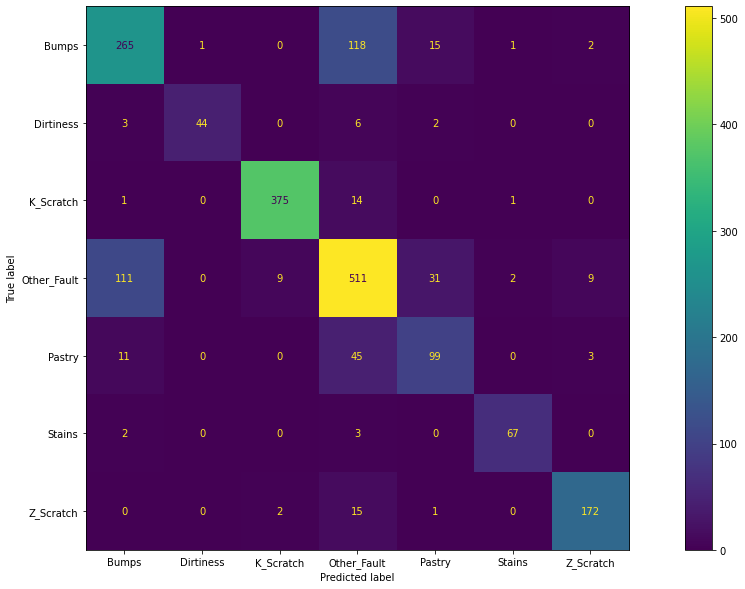

In [42]:
# Матрица ошибок
fig_cmd

[Text(0, 0, '402'),
 Text(0, 0, '55'),
 Text(0, 0, '391'),
 Text(0, 0, '673'),
 Text(0, 0, '158'),
 Text(0, 0, '72'),
 Text(0, 0, '190')]

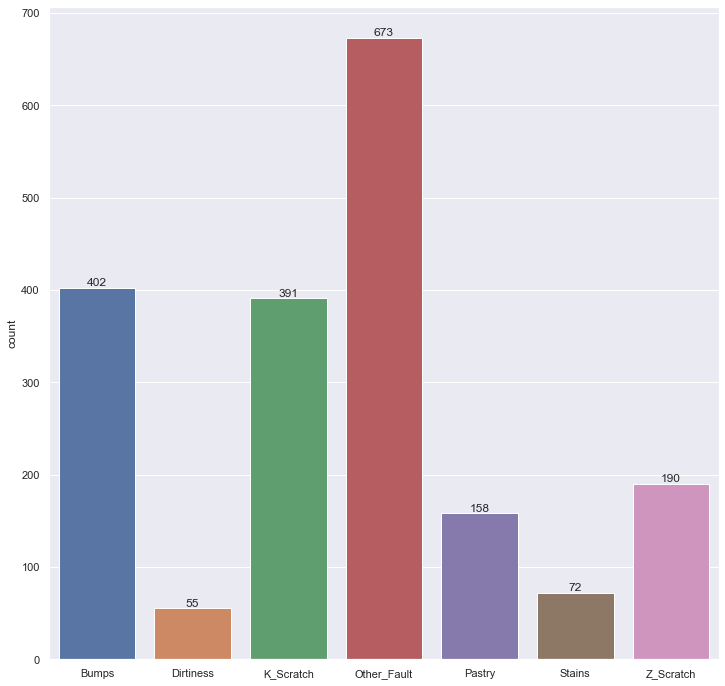

In [263]:
# Исходные метки
ax_count = sns.countplot(x=le.inverse_transform(steel_long_names["Fault_Label"]), order=le_name_mapping.keys())
ax_count.bar_label(ax_count.containers[0])

In [75]:
# Строки - предсказания, столбцы - реальные значения
conf_matr_df = pd.DataFrame(confusion_matrix(y_true=y_steel, y_pred=lgb_predict["Label"].astype("int32")), columns=le_name_mapping.keys(), index=le_name_mapping.keys()) 

In [224]:
conf_matr_df["Total"] = conf_matr_df.sum(axis=0)

In [225]:
conf_matr_df#.sum(axis=0)

,Bumps,Dirtiness,K_Scratch,Other_Fault,Pastry,Stains,Z_Scratch,Total
Bumps,265,1,0,118,15,1,2,393
Dirtiness,3,44,0,6,2,0,0,45
K_Scratch,1,0,375,14,0,1,0,386
Other_Fault,111,0,9,511,31,2,9,712
Pastry,11,0,0,45,99,0,3,148
Stains,2,0,0,3,0,67,0,71
Z_Scratch,0,0,2,15,1,0,172,186


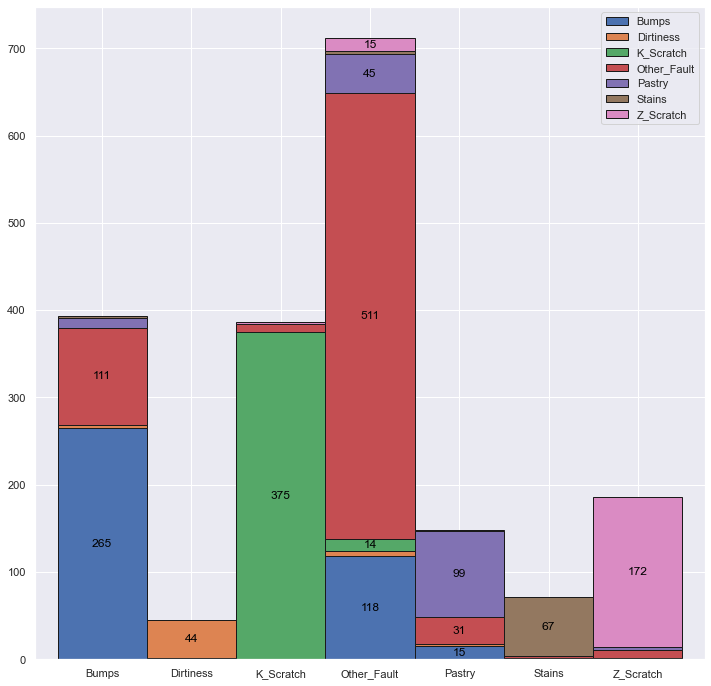

In [355]:
# https://stackoverflow.com/questions/69872543/how-to-plot-a-stacked-bar-with-annotations-for-multiple-groups
# вероятно, из-за наличия нулевых значений корректно предложенный метод для новой matplotlib 3.5.1 не отрабатывает
sns.set()
axd = conf_matr_df.iloc[:, :-1].T.plot(kind='bar', stacked=True, ec='k', rot=0, width=1, legend=True)
for c in axd.containers:
    labels = [int(v) if v >= 13 else "" for v in c.datavalues] # для читаемости
    axd.bar_label(c, labels=labels, label_type='center', color="black")